Hello fellow Kagglers,

This notebook demonstrates the generation of a dataset with melspectrograms in PNG format that are saved in a single dictionary.

The audio files are converted to melspectrograms and saved in raw PNG bytes for efficient saving.

In a training notebook the dictionary can be loaded in memory and decoding is quick as the raw PNG bytes are already loaded in working memory.

The next step is to select the parts of the melspectrograms which are likely to contain a bird call, which will be shown in the soon to be released training notebook.

Happy Kaggling!

**UPDATES**

**V2**
* hardcoded sampling rate of 32K
* updated spectrogram settings to get 5s windows of exactly 320 pixels
* normalizing audio

In [1]:
# !pip install /kaggle/input/noisereduce3/noisereduce-3.0.2-py3-none-any.whl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio

from tqdm.notebook import tqdm

import librosa
# import noisereduce as nr
import cv2
import pickle
import lzma

# Configuration

In [3]:
class Config():
    # Horizontal melspectrogram resolution
    MELSPEC_H = 128
    # Competition Root Folder
    ROOT_FOLDER = '/kaggle/input/birdclef-2024'
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000
    N_FFT = 2000
    HOP_LENGTH = 500
    
CONFIG = Config()

# Sample Submission

In [4]:
sample_submission = pd.read_csv('/kaggle/input/birdclef-2024/sample_submission.csv')

# Set labels
CONFIG.LABELS = sample_submission.columns[1:]
CONFIG.N_LABELS = len(CONFIG.LABELS)
print(f'# labels: {CONFIG.N_LABELS}')

display(sample_submission.head())

# labels: 182


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


# Train MetaData

In [5]:
train_metadata_df = pd.read_csv(
        '/kaggle/input/birdclef-2024/train_metadata.csv',
        dtype={
            'secondary_labels': 'string',
            'primary_label': 'category',
        },
    )
print(len(train_metadata_df))
# train_metadata_df = train_metadata_df.drop_duplicates(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude'])
print(len(train_metadata_df))

# Convert secondary_labels to iterable tuple
def parse_secondary_labels(s):
    s = s.strip("[']")
    s = s.split("', '")
    return tuple([e for e in s if len(e) > 0])

train_metadata_df['secondary_labels'] = train_metadata_df['secondary_labels'].apply(parse_secondary_labels)

# Number of samples
CONFIG.N_SAMPLES = len(train_metadata_df)
print(f'# Samples: {CONFIG.N_SAMPLES:,}')

display(train_metadata_df.head())
display(train_metadata_df.info())

24459
24459
# Samples: 24,459


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,(),['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,(),['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,(),['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,(),['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,(),['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   primary_label     24459 non-null  category
 1   secondary_labels  24459 non-null  object  
 2   type              24459 non-null  object  
 3   latitude          24081 non-null  float64 
 4   longitude         24081 non-null  float64 
 5   scientific_name   24459 non-null  object  
 6   common_name       24459 non-null  object  
 7   author            24459 non-null  object  
 8   license           24459 non-null  object  
 9   rating            24459 non-null  float64 
 10  url               24459 non-null  object  
 11  filename          24459 non-null  object  
dtypes: category(1), float64(3), object(8)
memory usage: 2.1+ MB


None

# Exploratory Data Analysis

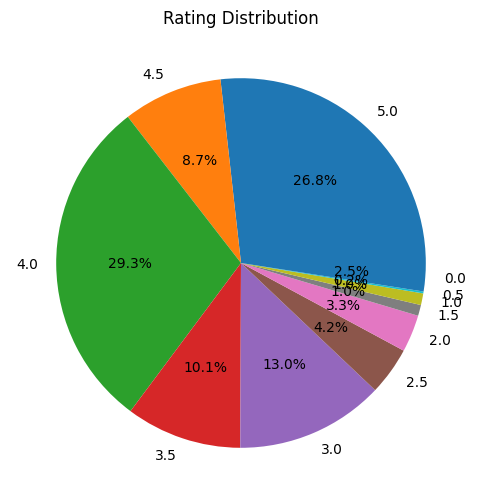

In [6]:
# Rating value counts
vc = train_metadata_df['rating'].value_counts().sort_index(ascending=False)

plt.figure(figsize=(8, 6))
plt.title('Rating Distribution')
plt.pie(vc, labels=vc.index, autopct='%1.1f%%')
plt.show()

In [7]:
# def SpectralNoiseReduction(audio_data, sr, min_length_sec=5):
#     # Skip processing if the length of the audio data is less than the specified minimum length in seconds
#     if len(audio_data) < sr * min_length_sec:
#         return audio_data

#     # Calculate the transition of noise levels across the audio data using a window size of 3 seconds and an overlap of 1.5 seconds
#     hop_length = int(sr * 1.5)  # 1.5 seconds overlap
#     win_length = int(sr * 3)    # 3 seconds window size
#     rms = librosa.feature.rms(y=audio_data, frame_length=win_length, hop_length=hop_length)

#     # Identify the time with the smallest noise level
#     noise_sec = 1  # noise reference length in seconds
#     min_rms_idx = np.argmin(rms)  # index of the minimum RMS value
#     start_idx = min_rms_idx * hop_length
#     end_idx = start_idx + sr * noise_sec  # Extract 1 second of data around the time of minimum noise

#     # Adjust the indices to make sure they are within the bounds of the audio data
#     start_idx = max(0, start_idx)  # Ensure start index is not negative
#     end_idx = min(len(audio_data), end_idx)  # Ensure end index does not exceed the length of the audio data

#     # Use the extracted data as the reference noise data
#     noise_data = audio_data[start_idx:end_idx]

#     # Perform noise reduction
#     return nr.reduce_noise(y=audio_data, sr=sr, y_noise=noise_data)

# OGG → Melspectrogram Conversion

In [8]:
# Convert OOG audio files to melspectrogram encoded as PNG bytes
def ogg2melspectrogram(file_path):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=CONFIG.SR)
#     y = SpectralNoiseReduction(y, CONFIG.SR)
    # Normalize audio
    y = librosa.util.normalize(y)
    # Convert to mel spectrogram
    spec = librosa.feature.melspectrogram(
        y=y,
        sr=CONFIG.SR, # sample rate
        n_fft=CONFIG.N_FFT, # number of samples in window 
        hop_length=CONFIG.HOP_LENGTH, # step size of window
        n_mels=CONFIG.MELSPEC_H, # horizontal resolution from fmin→fmax in log scale
        fmin=40, # minimum frequency
        fmax=15000, # maximum frequency
        power=2.0, # intensity^power for log scale
    )
    # Convert to Db
    spec = librosa.power_to_db(spec, ref=CONFIG.TOP_DB)
    # Normalize 0-min
    spec = spec - spec.min()
    # Normalize 0-255
    spec = (spec / spec.max() * 255).astype(np.uint8)
    # Convert to PNG bytes
    _, spec_png_uint8 = cv2.imencode('.png', spec)
    spec_png_bytes = bytes(spec_png_uint8)
    
    return spec_png_bytes

In [9]:
# Maps a class to corresponding integer label
CLASS2LABEL = dict(zip(CONFIG.LABELS, np.arange(CONFIG.N_LABELS)))
# Label to class mapping
LABEL2CLASS = dict([(v,k) for k, v in CLASS2LABEL.items()])
# Create dataset
X = {}
y = {}
X_val = {}
y_val = {}
for idx, row in tqdm(train_metadata_df.iterrows(), total=CONFIG.N_SAMPLES):
    # Guard for absence of secundary label and minimum rating
    if row['rating'] >= CONFIG.MIN_RATING and len(row['secondary_labels']) == 0:
        # Save PNGs in X
        X[idx] = ogg2melspectrogram(f'{CONFIG.ROOT_FOLDER}/train_audio/{row.filename}')
        # Save labels in y
        y[idx] = CLASS2LABEL.get(row['primary_label'])
        
print(f'# Training Samples: {len(X):,}')

for idx, row in tqdm(train_metadata_df.iterrows(), total=CONFIG.N_SAMPLES):
    # Guard for absence of secundary label and minimum rating
    if row['rating'] < CONFIG.MIN_RATING and len(row['secondary_labels']) == 0:
        # Save PNGs in X
        X_val[idx] = ogg2melspectrogram(f'{CONFIG.ROOT_FOLDER}/train_audio/{row.filename}')
        # Save labels in y
        y_val[idx] = CLASS2LABEL.get(row['primary_label'])

print(f'# Validation Samples: {len(X_val):,}')

  0%|          | 0/24459 [00:00<?, ?it/s]

# Training Samples: 20,053


  0%|          | 0/24459 [00:00<?, ?it/s]

# Validation Samples: 2,514


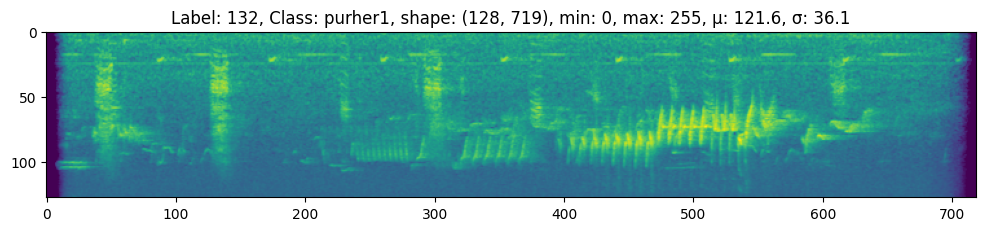

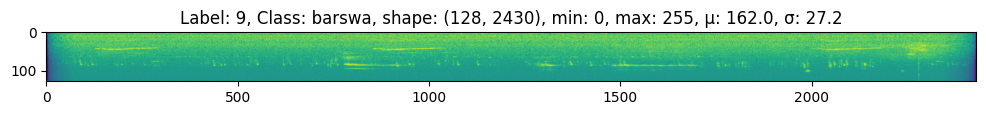

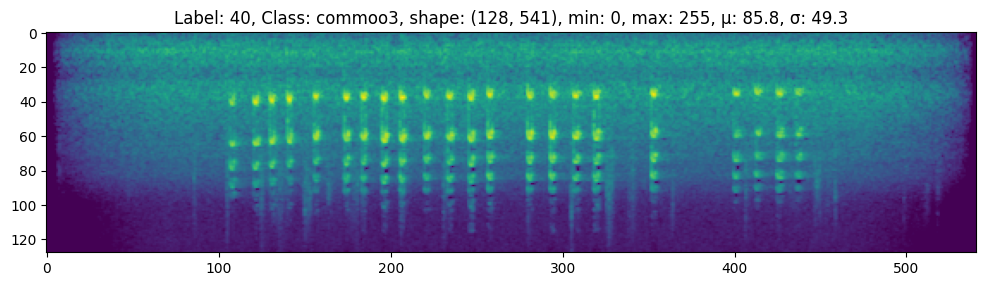

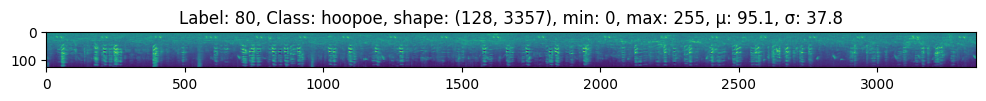

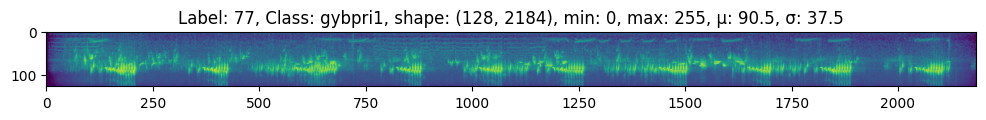

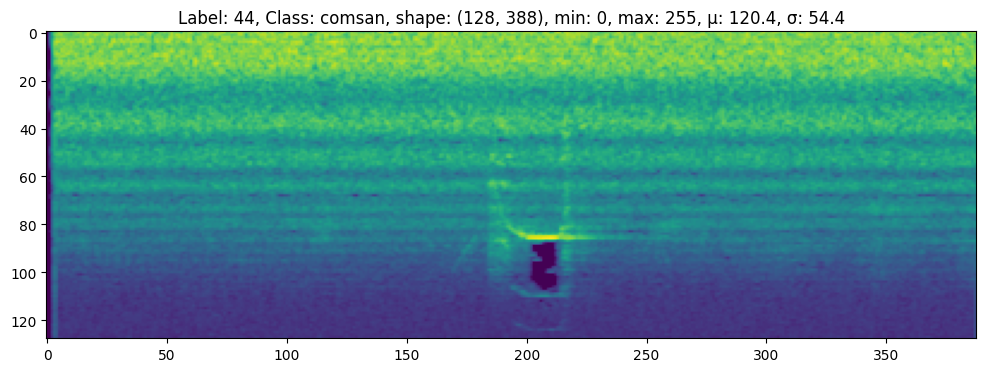

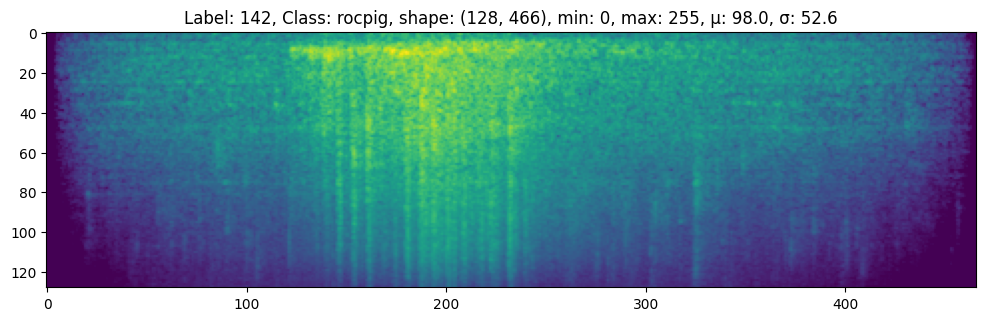

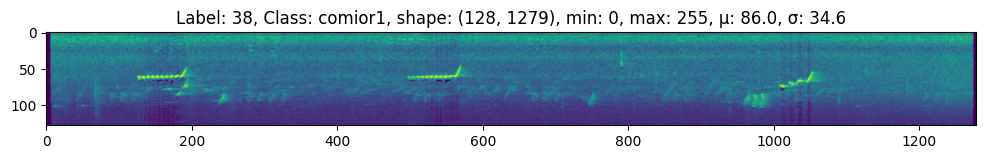

In [10]:
# Example Plots
def example_plots(X, y, N):
    np.random.seed(42)
    random_keys = np.random.choice(list(X.keys()), N)
    
    for k in random_keys:
        spec = imageio.imread(X[k])
        plt.figure(figsize=(12,5))
        plt.title(
                f'Label: {y[k]}, Class: {LABEL2CLASS[y[k]]}, shape: {spec.shape}, ' +
                f'min: {spec.min():.0f}, max: {spec.max():.0f}, ' +
                f'µ: {spec.mean():.1f}, σ: {spec.std():.1f}'
            )
        plt.imshow(spec)
        plt.show()
        
example_plots(X, y, 8)

In [11]:
# Write X
with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)
    
# Write y
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)
    
# Write X
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
    
# Write y
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)